In [1]:
# Monta tu Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Instala PyTorch si no está instalado
!pip install torch torchvision


Mounted at /content/drive
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlin

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models, datasets
from PIL import Image
import matplotlib.pyplot as plt
import copy
import os

# Asegúrate de que tienes acceso a una GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
def image_loader(image_name):
    image = Image.open(image_name)
    loader = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()])
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# Ruta de las imágenes en Google Drive
content_image_path = '/content/drive/MyDrive/Cosas del semestre 7/PDI/Proyecto PDI/Imagenes/Foto de prueba.jpg'
style_image_path = '/content/drive/MyDrive/Cosas del semestre 7/PDI/Proyecto PDI/Imagenes/Cielo estrellado.jpg'

# Cargar las imágenes de contenido y de estilo
content_image = image_loader(content_image_path)
style_image = image_loader(style_image_path)


In [4]:
class StyleTransferModel(nn.Module):
    def __init__(self, cnn, style_layers, content_layers):
        super(StyleTransferModel, self).__init__()
        self.cnn = cnn
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.model = nn.Sequential()
        self.style_losses = []
        self.content_losses = []

        i = 0
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = f'conv_{i}'
            elif isinstance(layer, nn.ReLU):
                name = f'relu_{i}'
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = f'pool_{i}'
            elif isinstance(layer, nn.BatchNorm2d):
                name = f'bn_{i}'
            else:
                raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')

            self.model.add_module(name, layer)

            if name in style_layers:
                target_feature = self.model(style_image).detach()
                style_loss = StyleLoss(target_feature)
                self.model.add_module(f'style_loss_{i}', style_loss)
                self.style_losses.append(style_loss)

            if name in content_layers:
                target = self.model(content_image).detach()
                content_loss = ContentLoss(target)
                self.model.add_module(f'content_loss_{i}', content_loss)
                self.content_losses.append(content_loss)

        for i in range(len(self.model) - 1, -1, -1):
            if isinstance(self.model[i], StyleLoss) or isinstance(self.model[i], ContentLoss):
                break

        self.model = self.model[:(i + 1)]

    def forward(self, x):
        self.model(x)

# Funciones de pérdida
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = nn.functional.mse_loss(input, self.target)
        return input

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = self.gram_matrix(target_feature).detach()

    def forward(self, input):
        G = self.gram_matrix(input)
        self.loss = nn.functional.mse_loss(G, self.target)
        return input

    def gram_matrix(self, input):
        a, b, c, d = input.size()
        features = input.view(a * b, c * d)
        G = torch.mm(features, features.t())
        return G.div(a * b * c * d)

# Capas de estilo y contenido
cnn = models.vgg19(pretrained=True).features.to(device).eval()
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
content_layers = ['conv_4']
model = StyleTransferModel(cnn, style_layers, content_layers).to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:10<00:00, 55.9MB/s]


run [50]:
Style Loss : 7.12551736831665 Content Loss: 2.9522743225097656

run [100]:
Style Loss : 0.6403696537017822 Content Loss: 2.8394274711608887

run [150]:
Style Loss : 0.3887448012828827 Content Loss: 2.469593048095703

run [200]:
Style Loss : 0.2728903293609619 Content Loss: 2.3242290019989014

run [250]:
Style Loss : 0.1941545009613037 Content Loss: 2.254997968673706

run [300]:
Style Loss : 0.14850780367851257 Content Loss: 2.2178211212158203



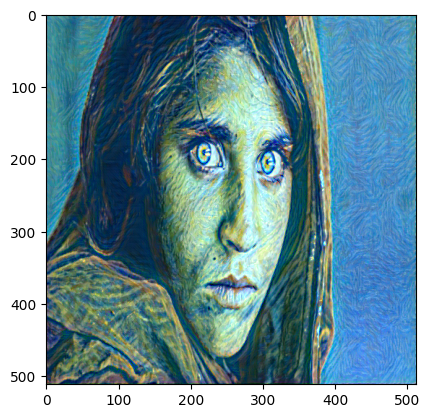

In [5]:
input_image = content_image.clone()
optimizer = optim.LBFGS([input_image.requires_grad_()])

run = [0]
while run[0] <= 300:
    def closure():
        input_image.data.clamp_(0, 1)
        optimizer.zero_grad()
        model(input_image)
        style_score = 0
        content_score = 0

        for sl in model.style_losses:
            style_score += sl.loss
        for cl in model.content_losses:
            content_score += cl.loss

        style_score *= 1000000
        loss = style_score + content_score
        loss.backward()

        run[0] += 1
        if run[0] % 50 == 0:
            print(f'run {run}:')
            print(f'Style Loss : {style_score.item()} Content Loss: {content_score.item()}')
            print()

        return style_score + content_score

    optimizer.step(closure)

input_image.data.clamp_(0, 1)

# Visualizar la imagen resultante
unloader = transforms.ToPILImage()
image = input_image.cpu().clone()
image = image.squeeze(0)
image = unloader(image)
plt.imshow(image)
plt.show()
